# Lecture 9) Regularisierung bei Neuronalen Netzen

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils.np_utils import to_categorical  
from keras.utils.vis_utils import plot_model



In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### 9.1) Weight Decay

Neuronale Netze sind typischerweise stark überparametrisiert. Das führt sehr oft dazu, daß Neuronale Netze zum "Overfitting" neigen.
Eine Möglichkeit dagegen vorzugehen war das Early Stopping (klappt nicht nur bei Neuronalen Netzen).  

Eine Alternative, die ebenfalls die Überparametrisierung reduziert ist das Weight Decay.
Dabei wird ein gewichteter Penalty-Term auf den Loss eingeführt:

Parameter für die Gewichtung ist $\lambda$ in $E(w)=E(w_0)+\lambda \sum \frac{1}{2}w^2$

In Keras läßt sich das mit Hilfe der "Layer Weight Regularizers" umsetzen.  
Für den Penalty-Term auf der Loss-Funktion sind die L1-Norm und die L2-Norm verfügbar (Vorlesung L2-Norm).

Die Regularisierung wirkt auf jeweils eine Schicht und wird als Option bei der Konfiguration der entsprechenden layer mit angegeben:

dense = tf.keras.layers.Dense(3, kernel_regularizer='l2')

Wir testen das Ganze mal am Beispiel der Klassifikation von Herzinfarkten...

In [3]:
Heart = pd.read_csv("../Daten/heart.csv")
#len(Heart)
#Heart.head()

Heart_y=Heart['AHD']
Heart_X=np.array(Heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope']])


Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))
#Heart_y



X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(Heart_X, Heart_y, test_size=0.3, shuffle='True')

scaler = StandardScaler()
X_train_H = scaler.fit_transform(X_train_H)
X_test_H = scaler.transform(X_test_H)

In [4]:
y_train_H_bin = to_categorical(y_train_H,num_classes = 2)
y_test_H_bin = to_categorical(y_test_H,num_classes = 2)
#print(y_train_bin);

Jetzt lassen wir das Modell für die Klassifikation einmal ohne irgendwelche Regularisierungen laufen und schauen uns die Verteilung der Gewichte nach dem Training an:

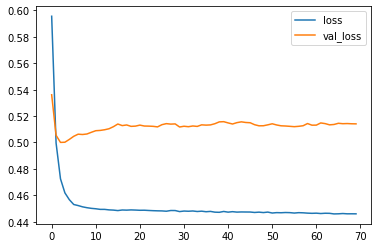

In [5]:
#EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

NNClassModel=Sequential()

NNClassModel.add(InputLayer(input_shape=(10,)))
NNClassModel.add(Dense(500,activation='tanh',use_bias=True))
NNClassModel.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(lr=0.005)
NNClassModel.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistory=NNClassModel.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=70,
          batch_size=1,
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

In [6]:
losslNN,acclNN=NNClassModel.evaluate(X_test_H, y_test_H_bin);
acclNN

3/3 [==============================] - 0s 2ms/step - loss: 0.5141 - accuracy: 0.7333


0.7333333492279053

Jetzt ist das Modell fertig trainiert.  
Auslesen der Gewichte nach 70 Epochen:

In [7]:
hidden1=NNClassModel.layers[0]
weights, biases = hidden1.get_weights()

#weights

np.mean(np.ndarray.flatten(weights))

2.6902724e-05

Darstellung der Gewichte (zwischen Input und Dense-Layer) als Histogramm.

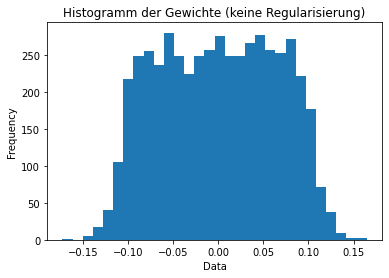

In [24]:
plt.hist(np.ndarray.flatten(weights), density=False, bins=30)  # density=False would make probabilities
plt.ylabel('Frequency')
plt.xlabel('Data');
plt.title('Histogramm der Gewichte (keine Regularisierung)');

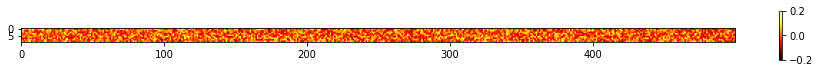

In [9]:
fig1=plt.figure(figsize=(16,9))
fig1=plt.imshow(weights, cmap='hot', vmin=-0.2, vmax=0.2)
plt.colorbar(fig1, shrink=0.1);


Jetzt wenden wir einen Square Weight Decay auf die Hidden-Layer an (alle Einstellungen wie vorher):

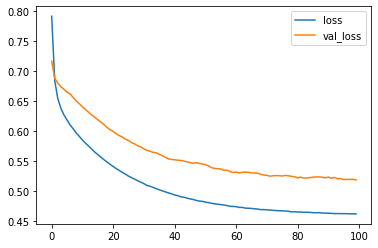

In [10]:
l2=tf.keras.regularizers.L2(l2=0.01) # Lambda = 0.01

NNClassModelWD=Sequential()

NNClassModelWD.add(InputLayer(input_shape=(10,)))
NNClassModelWD.add(Dense(500,activation='tanh',use_bias=True,kernel_regularizer='l2'))
NNClassModelWD.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(lr=0.005)
NNClassModelWD.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistoryWD=NNClassModelWD.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=100,
          batch_size=1,
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

In [11]:
losslNNWD,acclNNWD=NNClassModelWD.evaluate(X_test_H, y_test_H_bin);
acclNNWD

3/3 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.7333


0.7333333492279053

Schon an der Lernkurve sieht man eindeutig, daß der Effekt des Overfitting deutlich reduziert ist.  

Wenn alles gut gelaufen ist sollten jetzt jede Menge der Gewichte auf die 0 verschoben worden sein.
Wir lesen wieder die Gewichtmatrix aus und zeichnen das Histogramm:

In [12]:
hiddenWD=NNClassModelWD.layers[0]
weightsWD, biasesWD = hiddenWD.get_weights()

#weightsWD
np.mean(np.ndarray.flatten(weightsWD))

-0.0004858097

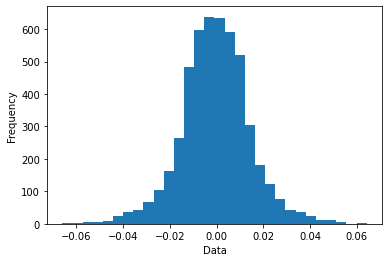

In [13]:
plt.hist(np.ndarray.flatten(weightsWD), density=False, bins=30)  # density=True would make probabilities
plt.ylabel('Frequency')
plt.xlabel('Data');

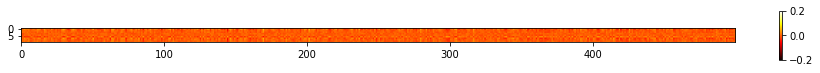

In [14]:
fig2=plt.figure(figsize=(16,9))
fig2=plt.imshow(weightsWD, vmin=-0.2, vmax=0.2,cmap='hot')
plt.colorbar(fig2, shrink=0.1);

### Aufgabe 1)

Das Netz mit dem L2-Weights Decay scheint noch nicht den minimalen Testfehler erreicht zu haben.

- Wie viele Epochen kann man trainieren ohne daß der Testfehler wieder steigt?
- Wie sieht dann die Gewichtsmatrix aus?
- welchen Einfluß hat der Parameter $\lambda$ in $E(w)=E(w_0)+\lambda \sum \frac{1}{2}w^2$ auf das Ergebnis?

Keras erlaubt auch einen Weight-Decay mit der L1-Norm.

- Welches Ergebnis liefert die zweite Penalty-Form?
- Wie lange trainiert dieses Modell bis zum optimalen Testfehler?
- Wie sehen dann die Gewichte aus?


### 9.2) Ensembles mit Keras

Wir haben gesehen, daß der Fehler eines Ensemble Modelles kleiner ist als der Fehler der Einzelmodelle.
Das ist eine feine Sache...

Machen wir also einen Versuch mit einem Ensemble von Klassifikationsnetzen.
Im einfachsten Fall ist die Struktur und das Training für alle Netze im Ensemble gleich. Die Modelle unterscheiden sich nur in ihrer Initialisierung.

Als erstes definieren wir also eine Funktion um Modelle mit einer speziellen Struktur zu trainieren.
Das Netz ist ein einfacher Klassifikator mit 50 Neuronen in der Hidden-Schicht.

In [15]:
# fit model on dataset
def fit_model(X_train_H, y_train_H_bin):
    # define model
    model = Sequential()
    model.add(InputLayer(input_shape=(10,)))
    model.add(Dense(50,activation='tanh',input_shape=(10,)))
    model.add(Dense(2,activation='softmax'))

    sgd = SGD(lr=0.1)
    model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

    model.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=100,
          batch_size=10,
          verbose=0)
    return model

In [16]:
# create directory for models
#from os import makedirs
#makedirs('models')

jetzt trainieren wir eine Anzahl (hier n_members=5) von Modellen mit unseren Trainingsdaten und speichern die Modelle im Ordner "models" unter den Namen model_1 bis model_5 ab.

In [17]:
# fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = fit_model(X_train_H, y_train_H_bin)
    # save model
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


hier eine Funktion, mit der man die Modelle ganz leicht wieder laden kann:

In [18]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/model_' + str(i + 1) + '.h5'
        # load model from file
        model = keras.models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

...jetzt laden wir die Modelle wieder:

In [19]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


die Modelle können jetzt einzeln ausgewertet oder für Prognosen verwendet werden:

In [20]:
# evaluate standalone models on test dataset
for model in members:

    lossEns,accEns = model.evaluate(X_test_H, y_test_H_bin)
    print('Model Accuracy: %.3f' % accEns)

3/3 [==============================] - 0s 1ms/step - loss: 0.7882 - accuracy: 0.7444
Model Accuracy: 0.744
3/3 [==============================] - 0s 1ms/step - loss: 0.7899 - accuracy: 0.7333
Model Accuracy: 0.733
3/3 [==============================] - 0s 2ms/step - loss: 0.7068 - accuracy: 0.7222
Model Accuracy: 0.722
3/3 [==============================] - 0s 1ms/step - loss: 0.7911 - accuracy: 0.7333
Model Accuracy: 0.733
3/3 [==============================] - 0s 1ms/step - loss: 0.7809 - accuracy: 0.7444
Model Accuracy: 0.744


In [21]:
# predict with standalone models on test dataset
all_y_hat = list()
all_y_hat_score=list()

for model in members:

    y_hat = model.predict(X_test_H)
    y_hat_score=np.round(y_hat) #score for class =1 else 0
    all_y_hat.append(y_hat)
    all_y_hat_score.append(y_hat_score)
    

In [22]:
np.shape(all_y_hat)

#all_y_hat[3]

(5, 90, 2)

der score kann für jedes Modell einzeln berechnet werden aus den Predictions:

In [23]:
test_accuracyEns = accuracy_score(all_y_hat_score[0],y_test_H_bin)*100
test_accuracyEns

74.44444444444444

### Aufgabe 2)

Für eine Ensemble-Prognose muß man irgendwie die Mehrheitsentscheidung berechnen (im Fall einer Regression tut es der Mittelwert).

- Berechnen Sie eine Ensemble-Prognose aus der Mehrheitsentscheidung.
- Wie schneidet das Ensemble-Modell ab?